In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

import os
import cv2

import numpy as np

Using TensorFlow backend.


In [2]:
path = 'str' # 데이터셋 경로
image_size = 128 # 이미지 크기
test_size = 0.15 # test set 비율

# 데이터셋 내 폴더들을 리스트로 추출
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

# 각 폴더 내 이미지 파일들을 불러와서 흑백으로 변환하고 라벨링
images = []
labels = []
for i, folder in enumerate(folders):
    print(i, folder)
    image_names = os.listdir(os.path.join(path, folder))
    for image_name in image_names:
        image_path = os.path.join(path, folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)
        labels.append(i)

# 불러온 이미지와 라벨을 numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# train과 test set을 나눔
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

0 left1
1 left2
2 left3
3 left4
4 no
5 right1
6 right2
7 right3
8 right4
9 str1
10 str2
11 str3
12 str4


In [3]:
# 크기 확인
print('x_train : {}'.format(X_train.shape))
print('Y-train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(X_test.shape))

x_train : (2465, 128, 128)
Y-train shape: (2465,)
x_test shape: (435, 128, 128)


In [4]:
# train과 valid 파일 분
X_train, X_valid, y_train, y_valid= train_test_split(
    X_train, y_train, test_size=.1766, random_state=1234,)

# 흑백 이미지의 경우 채널 축을 추가하여 차원을 (샘플 수, 높이, 너비, 채널)으로 변경합니다.
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


In [5]:
#input size와 shape 확인
im_rows=128
im_cols=128
batch_size=64
im_shape=(im_rows, im_cols, 1)
X_test_expanded = np.expand_dims(X_test, axis=-1)
print(im_shape)
print('x_train shape: {}'.format(X_train.shape))
print('x_test shape: {}'.format(X_valid.shape))

(128, 128, 1)
x_train shape: (2029, 128, 128, 1)
x_test shape: (436, 128, 128, 1)


In [9]:
#cnn 모델 생성

cnn_model= Sequential([
    Conv2D(filters=32, kernel_size=9, activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=7, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(13, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

In [10]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 120, 120, 32)      2624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 256)       401664    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 256)       1638656   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 256)         590080    
__________

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# val_loss가 epoch 10 이상 오르지 않으면 stop
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 콜백 함수 정의
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# 모델 훈련 과정에서 콜백 함수를 사용하여 최고의 성능을 보인 모델을 저장

history=cnn_model.fit(
    np.array(X_train), np.array(y_train), batch_size=64,
    epochs=250, verbose=2,
    validation_data=(np.array(X_valid),np.array(y_valid)),
    callbacks=[early_stopping, checkpoint]
)

Train on 2029 samples, validate on 436 samples
Epoch 1/250
 - 119s - loss: 3.0666 - acc: 0.2336 - val_loss: 2.3619 - val_acc: 0.2913

Epoch 00001: val_loss improved from inf to 2.36194, saving model to best_emotion_model.h5
Epoch 2/250
 - 116s - loss: 2.3383 - acc: 0.3144 - val_loss: 2.3846 - val_acc: 0.2913

Epoch 00002: val_loss did not improve
Epoch 3/250
 - 121s - loss: 2.2823 - acc: 0.3223 - val_loss: 2.3105 - val_acc: 0.2913

Epoch 00003: val_loss improved from 2.36194 to 2.31046, saving model to best_emotion_model.h5
Epoch 4/250
 - 122s - loss: 2.1792 - acc: 0.3228 - val_loss: 2.1893 - val_acc: 0.2913

Epoch 00004: val_loss improved from 2.31046 to 2.18926, saving model to best_emotion_model.h5
Epoch 5/250
 - 122s - loss: 2.0310 - acc: 0.3228 - val_loss: 2.0627 - val_acc: 0.2913

Epoch 00005: val_loss improved from 2.18926 to 2.06267, saving model to best_emotion_model.h5
Epoch 6/250
 - 117s - loss: 1.9281 - acc: 0.3243 - val_loss: 1.9233 - val_acc: 0.3073

Epoch 00006: val_loss

In [14]:
# test에 대한 loss와 accuracy 확인인
scor = cnn_model.evaluate( np.array(X_test),  np.array(y_test), verbose=0)

print('test los {:.4f}'.format(scor[0]))
print('test acc {:.4f}'.format(scor[1]))

test los 0.1009
test acc 0.9770


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


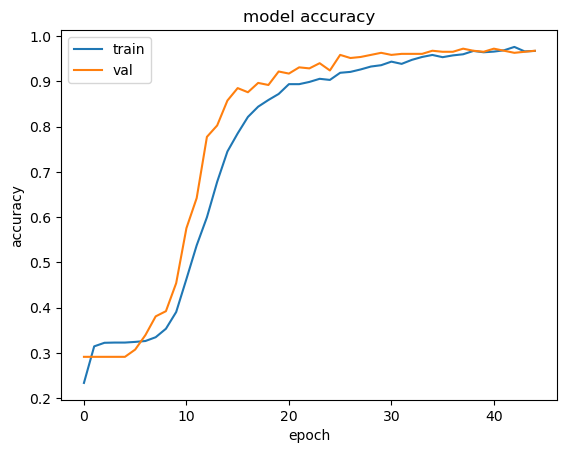

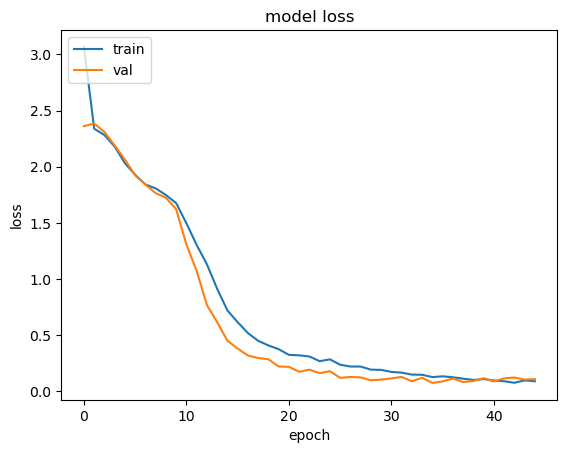

In [16]:
# 히스토리에 있는 키들 출력력
print(history.history.keys())
# accuracy의 history를 그래프로 보여 줌
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss history를 그래포로 보여 줌
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()